**Paper Name: An Efficient Ensemble Approach for Alzheimer’s Disease
Detection Using an Adaptive Synthetic Technique and
Deep Learning**

**Link: https://drive.google.com/file/d/1CdE1U4qNrfR_U799JvTfw8K0CvgA-bF-/view?usp=drive_link**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imghdr
from torchvision.transforms import v2 as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import pickle
import os
import random
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
gpu_device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

In [8]:
data_dir = '/kaggle/input/alzheimer-dataset/Alzheimer_s Dataset'

In [9]:
#Custom Dataset

class AlzheimerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [10]:
#Loading and preprocessing function

def load_and_preprocess_data(data_dir):
    classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
    X = []
    y = []
    for i, class_name in enumerate(classes):
        for split in ['train', 'test']:
            class_dir = os.path.join(data_dir, split, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = Image.open(img_path).convert('RGB')
                X.append(img)
                y.append(i)
    return X, np.array(y)

In [11]:
#Adasyn Function

import numpy as np
from imblearn.over_sampling import ADASYN
from PIL import Image

def apply_adasyn(X, y):
    # Convert PIL Images to numpy arrays
    X_arrays = [np.array(img) for img in X]
    
    # Get the shape of the images
    img_shape = X_arrays[0].shape
    
    # Reshape the arrays to 2D for ADASYN
    X_reshaped = np.array([x.flatten() for x in X_arrays])
    
    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_reshaped, y)
    
    # Reshape back to original image shape
    X_balanced = [x.reshape(img_shape) for x in X_resampled]
    
    # Convert back to PIL Images
    X_balanced = [Image.fromarray(x.astype('uint8')) for x in X_balanced]
    
    return X_balanced, y_resampled

In [13]:
#Dataset split function
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
#Data Preperation
X, y = load_and_preprocess_data(data_dir)

In [15]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f'X_train length: {len(X_train)}')
print(f'X_val length: {len(X_val)}')
print(f'X_test length: {len(X_test)}')

X_train length: 4480
X_val length: 640
X_test length: 1280


In [16]:
# Apply ADASYN
X_balanced, y_balanced = apply_adasyn(X_train, y_train)

In [17]:
# Define transforms
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [18]:
batch_size = 32

# Create datasets
train_dataset = AlzheimerDataset(X_balanced, y_balanced, transform=transform)
val_dataset = AlzheimerDataset(X_val, y_val, transform=transform)
test_dataset = AlzheimerDataset(X_test, y_test, transform=transform)
    
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)    

In [19]:
print(f'Train datset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')
print(f'Test dataset length: {len(test_dataset)}')

Train datset length: 9188
Validation dataset length: 640
Test dataset length: 1280


In [14]:
#Train Function

# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    
    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()
              

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_densenet121.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [15]:
#Densenet121 model

# Creating the model
def create_model(num_classes=4):
    # Load the pre-trained DenseNet121 model
    model = models.densenet121(pretrained=True)
    
    # Get the number of input features to the final classifier (which is the fully connected layer in DenseNet)
    in_features = model.classifier.in_features
    
    # Replace the final fully connected layer to match the number of classes
    model.classifier = nn.Linear(in_features, num_classes)
    
    return model


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 190MB/s]


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:01<00:00, 11.69batch/s]


--> Epoch Number : 1 | Training Loss : 0.5904 | Validation Loss : 0.709 | Train Accuracy : 74.02% | Validation Accuracy : 68.91%
Validation loss decreased (inf --> 0.708977).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:01<00:00, 11.65batch/s]


--> Epoch Number : 2 | Training Loss : 0.2093 | Validation Loss : 0.2092 | Train Accuracy : 92.13% | Validation Accuracy : 92.5%
Validation loss decreased (0.708977 --> 0.209226).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:01<00:00, 11.76batch/s]


--> Epoch Number : 3 | Training Loss : 0.0904 | Validation Loss : 0.0981 | Train Accuracy : 97.24% | Validation Accuracy : 96.56%
Validation loss decreased (0.209226 --> 0.098064).  Saving model ...


Epoch 4/50: 100%|██████████| 20/20 [00:01<00:00, 11.76batch/s]


--> Epoch Number : 4 | Training Loss : 0.0554 | Validation Loss : 0.3366 | Train Accuracy : 98.28% | Validation Accuracy : 88.91%
No reduction in validation loss | Patience count: 1


Epoch 5/50: 100%|██████████| 20/20 [00:01<00:00, 11.52batch/s]


--> Epoch Number : 5 | Training Loss : 0.0377 | Validation Loss : 0.1103 | Train Accuracy : 98.8% | Validation Accuracy : 96.25%
No reduction in validation loss | Patience count: 2


Epoch 6/50: 100%|██████████| 20/20 [00:01<00:00, 11.60batch/s]


--> Epoch Number : 6 | Training Loss : 0.0377 | Validation Loss : 0.1091 | Train Accuracy : 98.84% | Validation Accuracy : 95.62%
No reduction in validation loss | Patience count: 3


Epoch 7/50: 100%|██████████| 20/20 [00:01<00:00, 11.32batch/s]


--> Epoch Number : 7 | Training Loss : 0.0243 | Validation Loss : 0.1175 | Train Accuracy : 99.42% | Validation Accuracy : 96.09%
No reduction in validation loss | Patience count: 4


Epoch 8/50: 100%|██████████| 20/20 [00:01<00:00, 11.67batch/s]


--> Epoch Number : 8 | Training Loss : 0.0517 | Validation Loss : 0.115 | Train Accuracy : 98.31% | Validation Accuracy : 94.69%
No reduction in validation loss | Patience count: 5


Epoch 9/50: 100%|██████████| 20/20 [00:01<00:00, 11.86batch/s]


--> Epoch Number : 9 | Training Loss : 0.0207 | Validation Loss : 0.1547 | Train Accuracy : 99.67% | Validation Accuracy : 94.69%
No reduction in validation loss | Patience count: 6


Epoch 10/50: 100%|██████████| 20/20 [00:01<00:00, 11.50batch/s]


--> Epoch Number : 10 | Training Loss : 0.0101 | Validation Loss : 0.0395 | Train Accuracy : 99.73% | Validation Accuracy : 98.44%
Validation loss decreased (0.098064 --> 0.039485).  Saving model ...


Epoch 11/50: 100%|██████████| 20/20 [00:01<00:00, 11.69batch/s]


--> Epoch Number : 11 | Training Loss : 0.0073 | Validation Loss : 0.0382 | Train Accuracy : 99.92% | Validation Accuracy : 98.28%
Validation loss decreased (0.039485 --> 0.038235).  Saving model ...


Epoch 12/50: 100%|██████████| 20/20 [00:01<00:00, 11.75batch/s]


--> Epoch Number : 12 | Training Loss : 0.0046 | Validation Loss : 0.0362 | Train Accuracy : 99.97% | Validation Accuracy : 98.59%
Validation loss decreased (0.038235 --> 0.036152).  Saving model ...


Epoch 13/50: 100%|██████████| 20/20 [00:01<00:00, 11.55batch/s]


--> Epoch Number : 13 | Training Loss : 0.0026 | Validation Loss : 0.0346 | Train Accuracy : 99.99% | Validation Accuracy : 98.75%
Validation loss decreased (0.036152 --> 0.034605).  Saving model ...


Epoch 14/50: 100%|██████████| 20/20 [00:01<00:00, 11.76batch/s]


--> Epoch Number : 14 | Training Loss : 0.0019 | Validation Loss : 0.0263 | Train Accuracy : 99.97% | Validation Accuracy : 99.22%
Validation loss decreased (0.034605 --> 0.026342).  Saving model ...


Epoch 15/50: 100%|██████████| 20/20 [00:01<00:00, 11.45batch/s]


--> Epoch Number : 15 | Training Loss : 0.002 | Validation Loss : 0.0246 | Train Accuracy : 99.98% | Validation Accuracy : 98.91%
Validation loss decreased (0.026342 --> 0.024563).  Saving model ...


Epoch 16/50: 100%|██████████| 20/20 [00:01<00:00, 11.08batch/s]


--> Epoch Number : 16 | Training Loss : 0.0014 | Validation Loss : 0.0305 | Train Accuracy : 100.0% | Validation Accuracy : 98.75%
No reduction in validation loss | Patience count: 1


Epoch 17/50: 100%|██████████| 20/20 [00:01<00:00, 11.63batch/s]


--> Epoch Number : 17 | Training Loss : 0.0083 | Validation Loss : 0.017 | Train Accuracy : 99.97% | Validation Accuracy : 99.53%
Validation loss decreased (0.024563 --> 0.017001).  Saving model ...


Epoch 18/50: 100%|██████████| 20/20 [00:01<00:00, 11.74batch/s]


--> Epoch Number : 18 | Training Loss : 0.004 | Validation Loss : 0.0211 | Train Accuracy : 99.91% | Validation Accuracy : 99.06%
No reduction in validation loss | Patience count: 1


Epoch 19/50: 100%|██████████| 20/20 [00:01<00:00, 11.65batch/s]


--> Epoch Number : 19 | Training Loss : 0.0017 | Validation Loss : 0.0281 | Train Accuracy : 100.0% | Validation Accuracy : 98.75%
No reduction in validation loss | Patience count: 2


Epoch 20/50: 100%|██████████| 20/20 [00:01<00:00, 11.80batch/s]


--> Epoch Number : 20 | Training Loss : 0.001 | Validation Loss : 0.021 | Train Accuracy : 100.0% | Validation Accuracy : 98.91%
No reduction in validation loss | Patience count: 3


Epoch 21/50: 100%|██████████| 20/20 [00:01<00:00, 11.50batch/s]


--> Epoch Number : 21 | Training Loss : 0.0022 | Validation Loss : 0.0309 | Train Accuracy : 99.99% | Validation Accuracy : 98.75%
No reduction in validation loss | Patience count: 4


Epoch 22/50: 100%|██████████| 20/20 [00:01<00:00, 11.54batch/s]


--> Epoch Number : 22 | Training Loss : 0.0043 | Validation Loss : 0.0269 | Train Accuracy : 99.97% | Validation Accuracy : 98.91%
No reduction in validation loss | Patience count: 5


Epoch 23/50: 100%|██████████| 20/20 [00:01<00:00, 11.40batch/s]


--> Epoch Number : 23 | Training Loss : 0.002 | Validation Loss : 0.0376 | Train Accuracy : 99.97% | Validation Accuracy : 98.44%
No reduction in validation loss | Patience count: 6


Epoch 24/50: 100%|██████████| 20/20 [00:01<00:00, 11.37batch/s]


--> Epoch Number : 24 | Training Loss : 0.0014 | Validation Loss : 0.0282 | Train Accuracy : 100.0% | Validation Accuracy : 98.75%
No reduction in validation loss | Patience count: 7


Epoch 25/50: 100%|██████████| 20/20 [00:01<00:00, 11.43batch/s]


--> Epoch Number : 25 | Training Loss : 0.0013 | Validation Loss : 0.0226 | Train Accuracy : 99.99% | Validation Accuracy : 99.06%
No reduction in validation loss | Patience count: 8


Epoch 26/50: 100%|██████████| 20/20 [00:01<00:00, 11.59batch/s]


--> Epoch Number : 26 | Training Loss : 0.0011 | Validation Loss : 0.0282 | Train Accuracy : 100.0% | Validation Accuracy : 98.59%
No reduction in validation loss | Patience count: 9


Epoch 27/50: 100%|██████████| 20/20 [00:01<00:00, 11.57batch/s]

--> Epoch Number : 27 | Training Loss : 0.0064 | Validation Loss : 0.0387 | Train Accuracy : 99.97% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 10
Early stopping triggered.


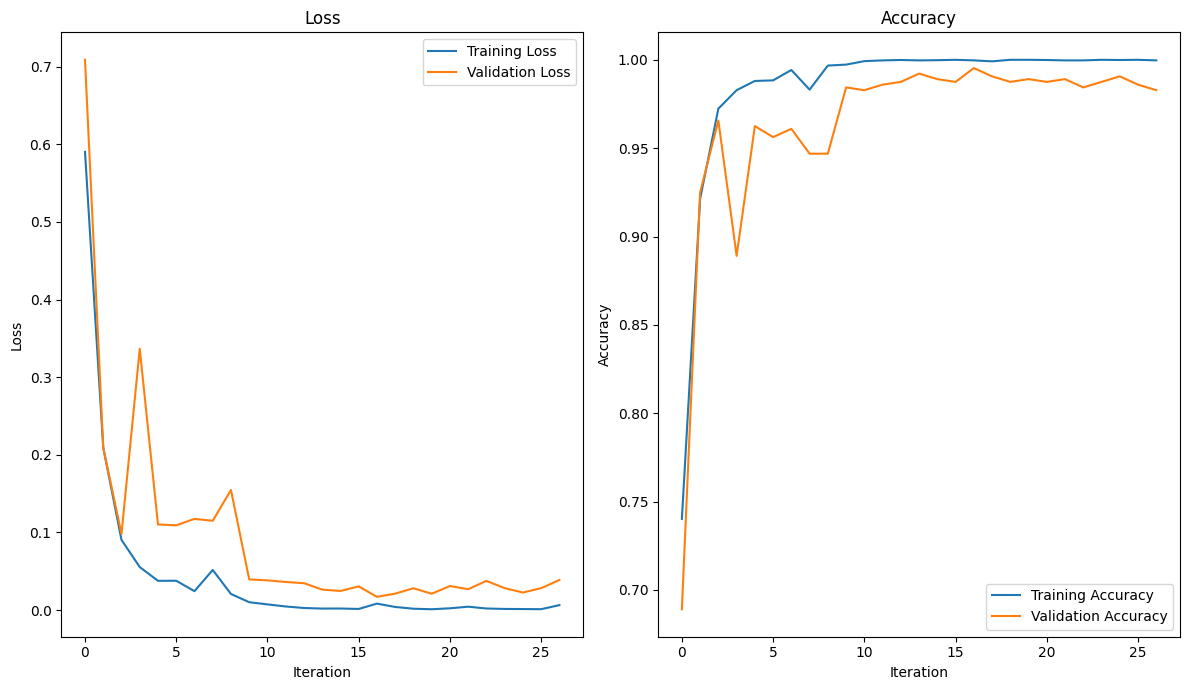

In [18]:
#Performance Curves

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [20]:
best_model = model
best_model.load_state_dict(torch.load('model_densenet121.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.0028, Test Acc: 0.9891


In [21]:
#Classification Report

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.99      0.98      0.99       640
VeryMildDemented       0.98      0.99      0.99       448

        accuracy                           0.99      1280
       macro avg       0.99      0.99      0.99      1280
    weighted avg       0.99      0.99      0.99      1280



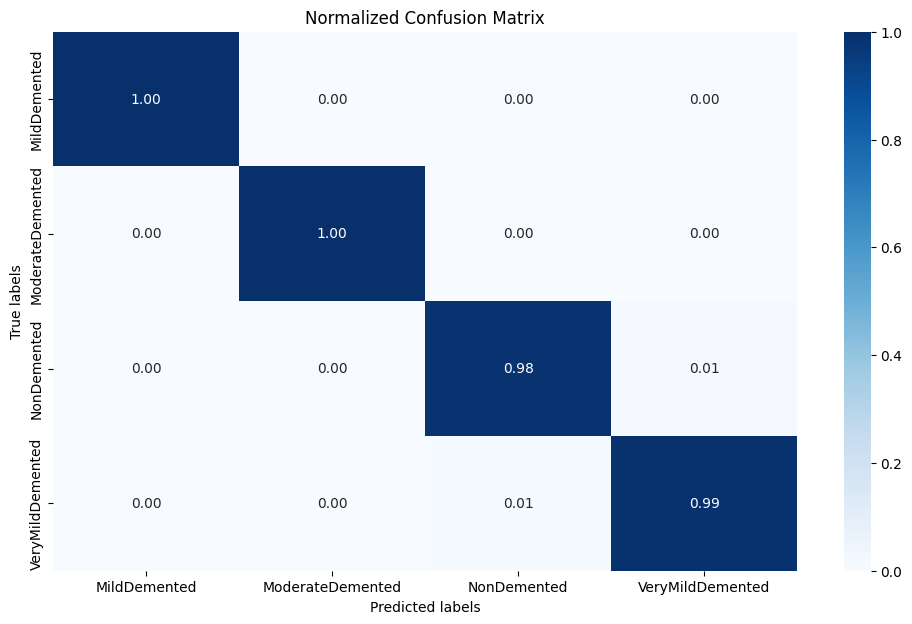

In [22]:
#Confusion Matrix

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


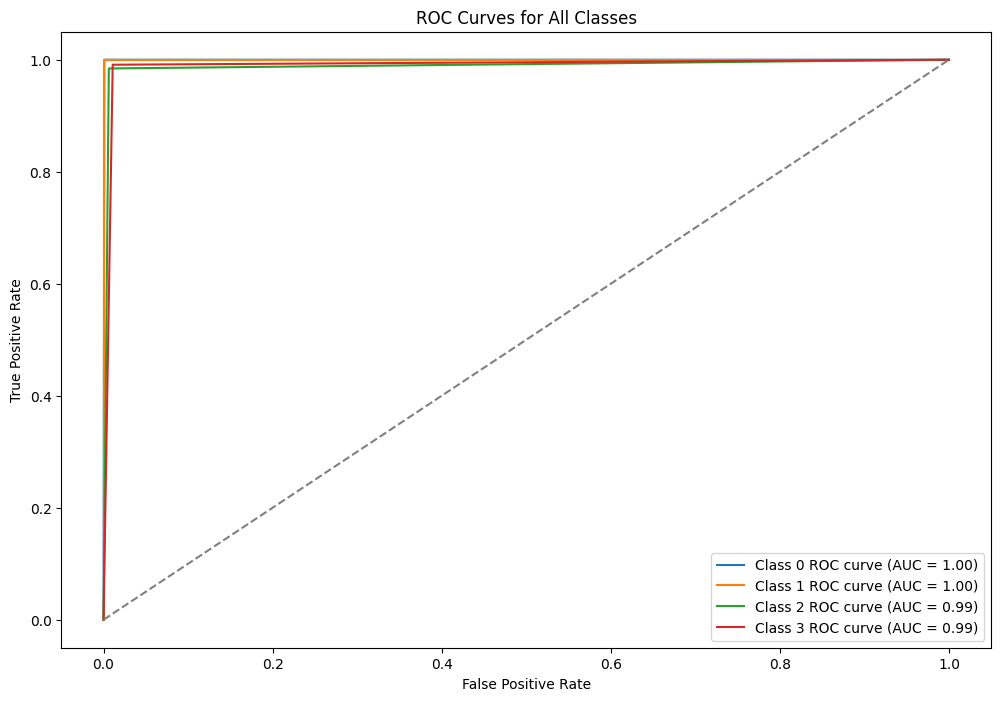

AUC for class 0: 1.00
AUC for class 1: 1.00
AUC for class 2: 0.99
AUC for class 3: 0.99


In [23]:
#ROC/AUC 

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


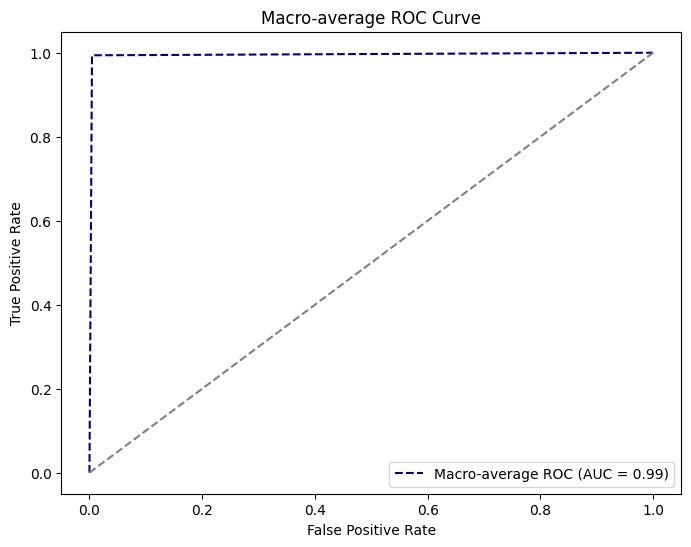

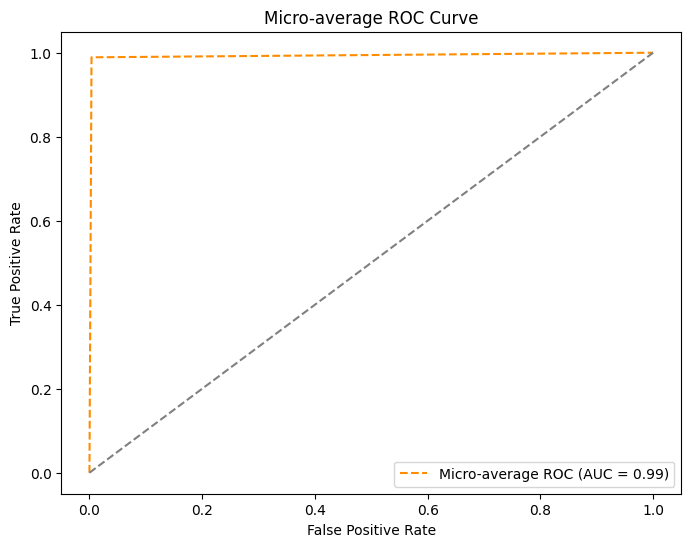

In [24]:
#ROC/AUC Combination

from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


**VGG16 model**

In [25]:
#Train Function

# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    
    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()
              

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_vgg16.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [26]:
# Creating the model
def create_model(num_classes=4):
    # Load the pre-trained VGG16 model
    model = models.vgg16(pretrained=True)
    
    # Get the number of input features to the final classifier
    in_features = model.classifier[6].in_features
    
    # Replace the final fully connected layer to match the number of classes
    model.classifier[6] = nn.Linear(in_features, num_classes)
    
    return model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 233MB/s] 


In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:02<00:00,  9.27batch/s]


--> Epoch Number : 1 | Training Loss : 0.8321 | Validation Loss : 0.7719 | Train Accuracy : 60.31% | Validation Accuracy : 65.31%
Validation loss decreased (inf --> 0.771918).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s]


--> Epoch Number : 2 | Training Loss : 0.5001 | Validation Loss : 0.6236 | Train Accuracy : 76.39% | Validation Accuracy : 72.66%
Validation loss decreased (0.771918 --> 0.623643).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s]


--> Epoch Number : 3 | Training Loss : 0.2886 | Validation Loss : 0.3359 | Train Accuracy : 87.93% | Validation Accuracy : 85.78%
Validation loss decreased (0.623643 --> 0.335885).  Saving model ...


Epoch 4/50: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s]


--> Epoch Number : 4 | Training Loss : 0.1467 | Validation Loss : 0.1908 | Train Accuracy : 94.6% | Validation Accuracy : 94.06%
Validation loss decreased (0.335885 --> 0.190776).  Saving model ...


Epoch 5/50: 100%|██████████| 20/20 [00:02<00:00,  9.27batch/s]


--> Epoch Number : 5 | Training Loss : 0.0651 | Validation Loss : 0.1155 | Train Accuracy : 97.4% | Validation Accuracy : 97.19%
Validation loss decreased (0.190776 --> 0.115522).  Saving model ...


Epoch 6/50: 100%|██████████| 20/20 [00:02<00:00,  9.35batch/s]


--> Epoch Number : 6 | Training Loss : 0.0577 | Validation Loss : 0.1583 | Train Accuracy : 97.93% | Validation Accuracy : 95.0%
No reduction in validation loss | Patience count: 1


Epoch 7/50: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s]


--> Epoch Number : 7 | Training Loss : 0.0414 | Validation Loss : 0.2242 | Train Accuracy : 98.67% | Validation Accuracy : 92.66%
No reduction in validation loss | Patience count: 2


Epoch 8/50: 100%|██████████| 20/20 [00:02<00:00,  9.31batch/s]


--> Epoch Number : 8 | Training Loss : 0.0325 | Validation Loss : 0.1996 | Train Accuracy : 98.98% | Validation Accuracy : 94.22%
No reduction in validation loss | Patience count: 3


Epoch 9/50: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s]


--> Epoch Number : 9 | Training Loss : 0.0361 | Validation Loss : 0.2475 | Train Accuracy : 98.75% | Validation Accuracy : 93.91%
No reduction in validation loss | Patience count: 4


Epoch 10/50: 100%|██████████| 20/20 [00:02<00:00,  9.15batch/s]


--> Epoch Number : 10 | Training Loss : 0.017 | Validation Loss : 0.2154 | Train Accuracy : 99.44% | Validation Accuracy : 93.75%
No reduction in validation loss | Patience count: 5


Epoch 11/50: 100%|██████████| 20/20 [00:02<00:00,  9.18batch/s]


--> Epoch Number : 11 | Training Loss : 0.041 | Validation Loss : 0.1246 | Train Accuracy : 98.51% | Validation Accuracy : 97.19%
No reduction in validation loss | Patience count: 6


Epoch 12/50: 100%|██████████| 20/20 [00:02<00:00,  9.18batch/s]


--> Epoch Number : 12 | Training Loss : 0.0036 | Validation Loss : 0.0889 | Train Accuracy : 99.92% | Validation Accuracy : 97.97%
Validation loss decreased (0.115522 --> 0.088933).  Saving model ...


Epoch 13/50: 100%|██████████| 20/20 [00:02<00:00,  8.84batch/s]


--> Epoch Number : 13 | Training Loss : 0.0005 | Validation Loss : 0.09 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 1


Epoch 14/50: 100%|██████████| 20/20 [00:02<00:00,  9.21batch/s]


--> Epoch Number : 14 | Training Loss : 0.0003 | Validation Loss : 0.093 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 2


Epoch 15/50: 100%|██████████| 20/20 [00:02<00:00,  9.39batch/s]


--> Epoch Number : 15 | Training Loss : 0.0002 | Validation Loss : 0.0954 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 3


Epoch 16/50: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s]


--> Epoch Number : 16 | Training Loss : 0.0001 | Validation Loss : 0.0974 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 4


Epoch 17/50: 100%|██████████| 20/20 [00:02<00:00,  9.16batch/s]


--> Epoch Number : 17 | Training Loss : 0.0001 | Validation Loss : 0.0998 | Train Accuracy : 100.0% | Validation Accuracy : 97.81%
No reduction in validation loss | Patience count: 5


Epoch 18/50: 100%|██████████| 20/20 [00:02<00:00,  9.20batch/s]


--> Epoch Number : 18 | Training Loss : 0.0001 | Validation Loss : 0.1015 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 6


Epoch 19/50: 100%|██████████| 20/20 [00:02<00:00,  9.27batch/s]


--> Epoch Number : 19 | Training Loss : 0.0001 | Validation Loss : 0.1017 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 7


Epoch 20/50: 100%|██████████| 20/20 [00:02<00:00,  9.26batch/s]


--> Epoch Number : 20 | Training Loss : 0.0001 | Validation Loss : 0.1018 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 8


Epoch 21/50: 100%|██████████| 20/20 [00:02<00:00,  9.04batch/s]


--> Epoch Number : 21 | Training Loss : 0.0001 | Validation Loss : 0.102 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 9


Epoch 22/50: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s]

--> Epoch Number : 22 | Training Loss : 0.0001 | Validation Loss : 0.1021 | Train Accuracy : 100.0% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 10
Early stopping triggered.


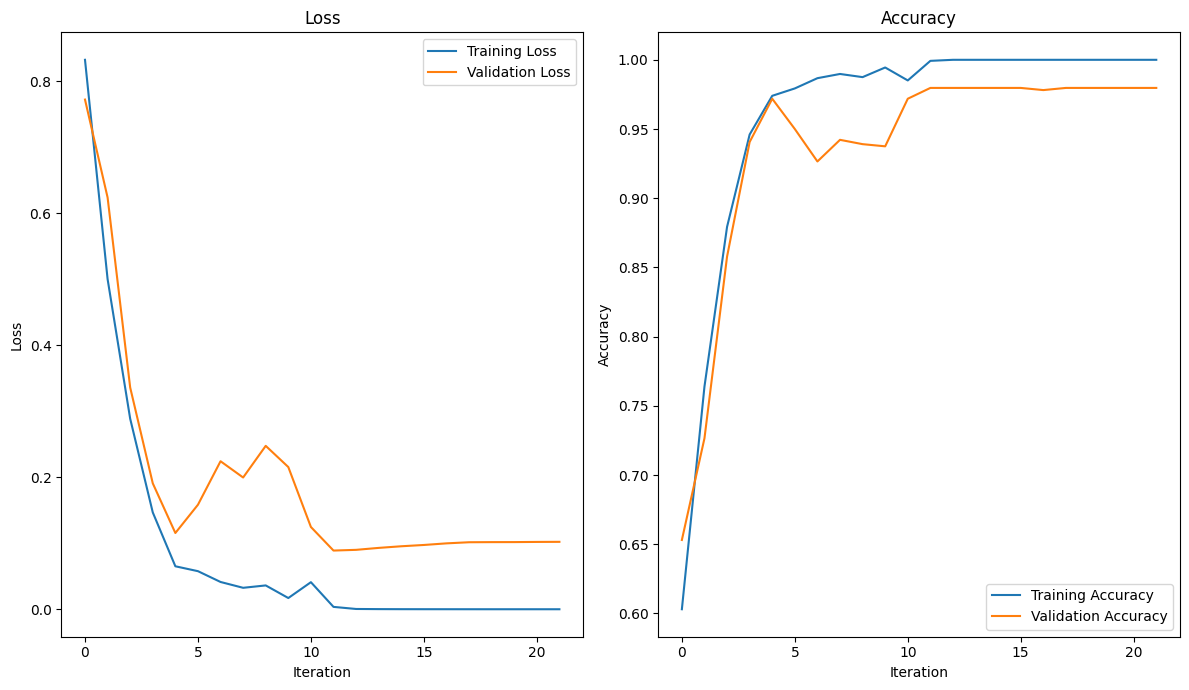

In [29]:
#Performance Curves

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [32]:
best_model = model
best_model.load_state_dict(torch.load('model_vgg16.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.0174, Test Acc: 0.9727


In [33]:
#Classification Report

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.96      0.96      0.96       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.97      0.98      0.98       640
VeryMildDemented       0.98      0.96      0.97       448

        accuracy                           0.97      1280
       macro avg       0.98      0.98      0.98      1280
    weighted avg       0.97      0.97      0.97      1280



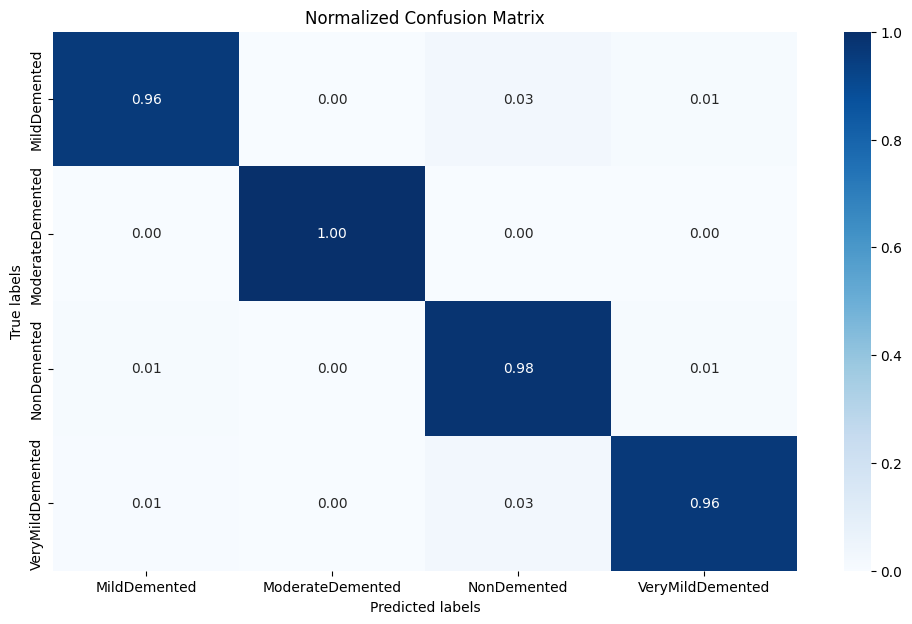

In [34]:
#Confusion Matrix

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


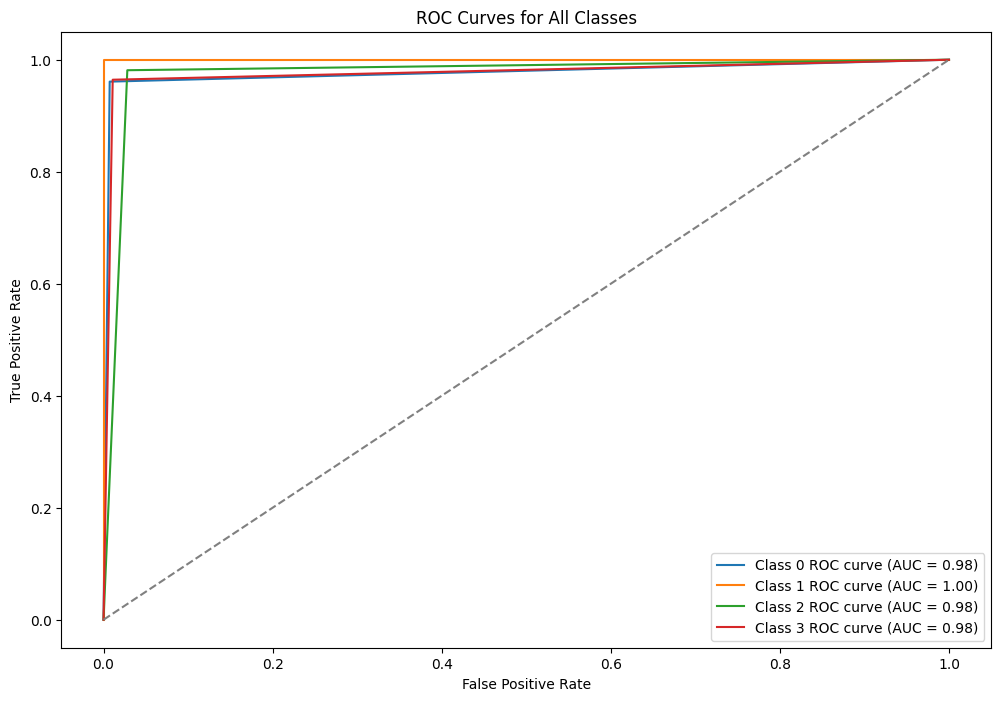

AUC for class 0: 0.98
AUC for class 1: 1.00
AUC for class 2: 0.98
AUC for class 3: 0.98


In [35]:
#ROC/AUC

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


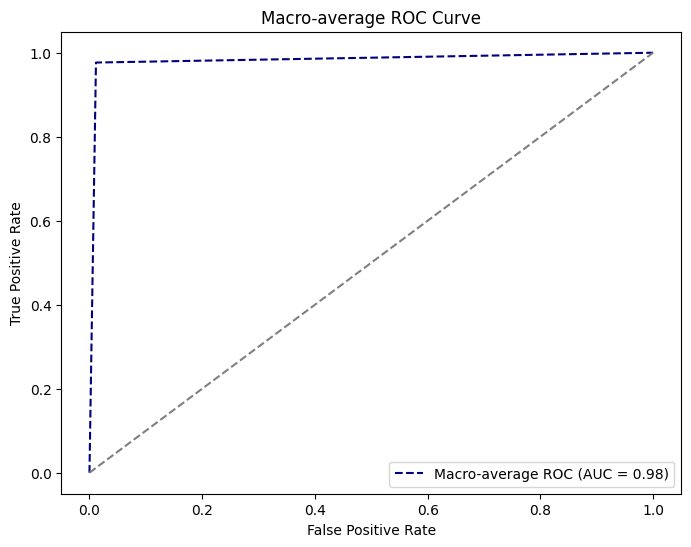

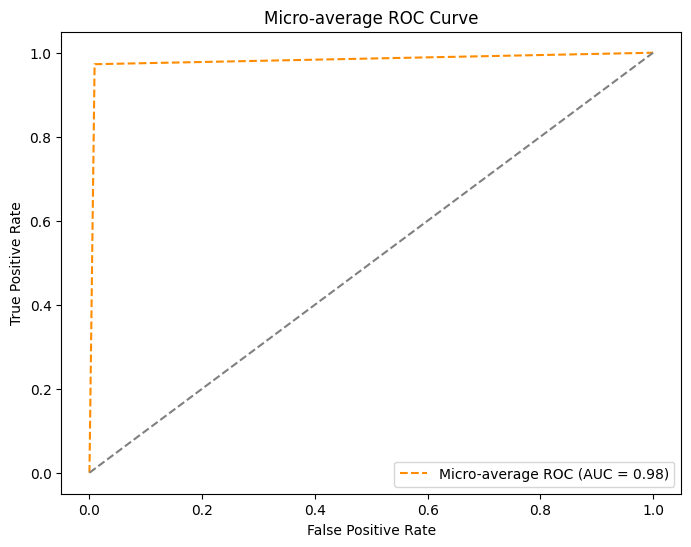

In [36]:
#ROC/AUC Combination
from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


**EfficientNet-B2 Model**

In [43]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=48365a925666ed5b7bd6b500eb06de3bed307dea325038b220bde391cb8154ee
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [44]:
#Training Function

# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):

    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()


        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)

                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_EfficientNet-B2.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

**model_EfficientNet-B2**

In [47]:
from efficientnet_pytorch import EfficientNet

In [48]:
# 5. Creating the model
def create_model(num_classes=4):
    model = EfficientNet.from_pretrained('efficientnet-b2')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    return model

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 83.8MB/s]


Loaded pretrained weights for efficientnet-b2


In [50]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:01<00:00, 12.18batch/s]


--> Epoch Number : 1 | Training Loss : 0.7578 | Validation Loss : 0.7431 | Train Accuracy : 66.61% | Validation Accuracy : 65.62%
Validation loss decreased (inf --> 0.743100).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:01<00:00, 12.15batch/s]


--> Epoch Number : 2 | Training Loss : 0.3618 | Validation Loss : 0.4673 | Train Accuracy : 85.61% | Validation Accuracy : 80.62%
Validation loss decreased (0.743100 --> 0.467307).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:01<00:00, 11.54batch/s]


--> Epoch Number : 3 | Training Loss : 0.182 | Validation Loss : 0.2418 | Train Accuracy : 93.54% | Validation Accuracy : 90.62%
Validation loss decreased (0.467307 --> 0.241825).  Saving model ...


Epoch 4/50: 100%|██████████| 20/20 [00:01<00:00, 12.11batch/s]


--> Epoch Number : 4 | Training Loss : 0.0924 | Validation Loss : 0.1307 | Train Accuracy : 96.65% | Validation Accuracy : 95.31%
Validation loss decreased (0.241825 --> 0.130698).  Saving model ...


Epoch 5/50: 100%|██████████| 20/20 [00:01<00:00, 12.16batch/s]


--> Epoch Number : 5 | Training Loss : 0.0695 | Validation Loss : 0.219 | Train Accuracy : 97.81% | Validation Accuracy : 92.34%
No reduction in validation loss | Patience count: 1


Epoch 6/50: 100%|██████████| 20/20 [00:01<00:00, 12.05batch/s]


--> Epoch Number : 6 | Training Loss : 0.0607 | Validation Loss : 0.1538 | Train Accuracy : 97.95% | Validation Accuracy : 95.47%
No reduction in validation loss | Patience count: 2


Epoch 7/50: 100%|██████████| 20/20 [00:01<00:00, 12.27batch/s]


--> Epoch Number : 7 | Training Loss : 0.0447 | Validation Loss : 0.1567 | Train Accuracy : 98.67% | Validation Accuracy : 94.38%
No reduction in validation loss | Patience count: 3


Epoch 8/50: 100%|██████████| 20/20 [00:01<00:00, 12.33batch/s]


--> Epoch Number : 8 | Training Loss : 0.0459 | Validation Loss : 0.1944 | Train Accuracy : 98.53% | Validation Accuracy : 93.12%
No reduction in validation loss | Patience count: 4


Epoch 9/50: 100%|██████████| 20/20 [00:01<00:00, 12.33batch/s]


--> Epoch Number : 9 | Training Loss : 0.0248 | Validation Loss : 0.1114 | Train Accuracy : 99.28% | Validation Accuracy : 96.56%
Validation loss decreased (0.130698 --> 0.111403).  Saving model ...


Epoch 10/50: 100%|██████████| 20/20 [00:01<00:00, 12.15batch/s]


--> Epoch Number : 10 | Training Loss : 0.0354 | Validation Loss : 0.1192 | Train Accuracy : 98.89% | Validation Accuracy : 95.62%
No reduction in validation loss | Patience count: 1


Epoch 11/50: 100%|██████████| 20/20 [00:01<00:00, 12.05batch/s]


--> Epoch Number : 11 | Training Loss : 0.0277 | Validation Loss : 0.0893 | Train Accuracy : 99.14% | Validation Accuracy : 97.5%
Validation loss decreased (0.111403 --> 0.089257).  Saving model ...


Epoch 12/50: 100%|██████████| 20/20 [00:01<00:00, 12.32batch/s]


--> Epoch Number : 12 | Training Loss : 0.0169 | Validation Loss : 0.0861 | Train Accuracy : 99.58% | Validation Accuracy : 97.34%
Validation loss decreased (0.089257 --> 0.086071).  Saving model ...


Epoch 13/50: 100%|██████████| 20/20 [00:01<00:00, 12.07batch/s]


--> Epoch Number : 13 | Training Loss : 0.0373 | Validation Loss : 0.0786 | Train Accuracy : 98.92% | Validation Accuracy : 97.81%
Validation loss decreased (0.086071 --> 0.078629).  Saving model ...


Epoch 14/50: 100%|██████████| 20/20 [00:01<00:00, 12.00batch/s]


--> Epoch Number : 14 | Training Loss : 0.0276 | Validation Loss : 0.1124 | Train Accuracy : 99.17% | Validation Accuracy : 96.72%
No reduction in validation loss | Patience count: 1


Epoch 15/50: 100%|██████████| 20/20 [00:01<00:00, 12.08batch/s]


--> Epoch Number : 15 | Training Loss : 0.0225 | Validation Loss : 0.0558 | Train Accuracy : 99.25% | Validation Accuracy : 98.44%
Validation loss decreased (0.078629 --> 0.055812).  Saving model ...


Epoch 16/50: 100%|██████████| 20/20 [00:01<00:00, 11.46batch/s]


--> Epoch Number : 16 | Training Loss : 0.0148 | Validation Loss : 0.0736 | Train Accuracy : 99.58% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 1


Epoch 17/50: 100%|██████████| 20/20 [00:01<00:00, 12.29batch/s]


--> Epoch Number : 17 | Training Loss : 0.016 | Validation Loss : 0.1228 | Train Accuracy : 99.5% | Validation Accuracy : 96.25%
No reduction in validation loss | Patience count: 2


Epoch 18/50: 100%|██████████| 20/20 [00:01<00:00, 12.45batch/s]


--> Epoch Number : 18 | Training Loss : 0.0277 | Validation Loss : 0.0919 | Train Accuracy : 99.13% | Validation Accuracy : 97.19%
No reduction in validation loss | Patience count: 3


Epoch 19/50: 100%|██████████| 20/20 [00:01<00:00, 12.28batch/s]


--> Epoch Number : 19 | Training Loss : 0.0153 | Validation Loss : 0.0929 | Train Accuracy : 99.59% | Validation Accuracy : 97.34%
No reduction in validation loss | Patience count: 4


Epoch 20/50: 100%|██████████| 20/20 [00:01<00:00, 12.27batch/s]


--> Epoch Number : 20 | Training Loss : 0.0165 | Validation Loss : 0.0906 | Train Accuracy : 99.44% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 5


Epoch 21/50: 100%|██████████| 20/20 [00:01<00:00, 12.17batch/s]


--> Epoch Number : 21 | Training Loss : 0.0142 | Validation Loss : 0.0579 | Train Accuracy : 99.5% | Validation Accuracy : 97.97%
No reduction in validation loss | Patience count: 6


Epoch 22/50: 100%|██████████| 20/20 [00:01<00:00, 12.34batch/s]


--> Epoch Number : 22 | Training Loss : 0.0081 | Validation Loss : 0.0369 | Train Accuracy : 99.81% | Validation Accuracy : 98.59%
Validation loss decreased (0.055812 --> 0.036922).  Saving model ...


Epoch 23/50: 100%|██████████| 20/20 [00:01<00:00, 12.25batch/s]


--> Epoch Number : 23 | Training Loss : 0.0062 | Validation Loss : 0.035 | Train Accuracy : 99.77% | Validation Accuracy : 98.28%
Validation loss decreased (0.036922 --> 0.035036).  Saving model ...


Epoch 24/50: 100%|██████████| 20/20 [00:01<00:00, 12.34batch/s]


--> Epoch Number : 24 | Training Loss : 0.0049 | Validation Loss : 0.0359 | Train Accuracy : 99.88% | Validation Accuracy : 98.75%
No reduction in validation loss | Patience count: 1


Epoch 25/50: 100%|██████████| 20/20 [00:01<00:00, 12.29batch/s]


--> Epoch Number : 25 | Training Loss : 0.0048 | Validation Loss : 0.0373 | Train Accuracy : 99.9% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 2


Epoch 26/50: 100%|██████████| 20/20 [00:01<00:00, 12.36batch/s]


--> Epoch Number : 26 | Training Loss : 0.0048 | Validation Loss : 0.0379 | Train Accuracy : 99.9% | Validation Accuracy : 98.59%
No reduction in validation loss | Patience count: 3


Epoch 27/50: 100%|██████████| 20/20 [00:01<00:00, 12.31batch/s]


--> Epoch Number : 27 | Training Loss : 0.0062 | Validation Loss : 0.0363 | Train Accuracy : 99.92% | Validation Accuracy : 98.44%
No reduction in validation loss | Patience count: 4


Epoch 28/50: 100%|██████████| 20/20 [00:01<00:00, 12.28batch/s]


--> Epoch Number : 28 | Training Loss : 0.0061 | Validation Loss : 0.0402 | Train Accuracy : 99.9% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 5


Epoch 29/50: 100%|██████████| 20/20 [00:01<00:00, 11.82batch/s]


--> Epoch Number : 29 | Training Loss : 0.0048 | Validation Loss : 0.0417 | Train Accuracy : 99.84% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 6


Epoch 30/50: 100%|██████████| 20/20 [00:01<00:00, 12.33batch/s]


--> Epoch Number : 30 | Training Loss : 0.0084 | Validation Loss : 0.0408 | Train Accuracy : 99.88% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 7


Epoch 31/50: 100%|██████████| 20/20 [00:01<00:00, 12.41batch/s]


--> Epoch Number : 31 | Training Loss : 0.0139 | Validation Loss : 0.0413 | Train Accuracy : 99.89% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 8


Epoch 32/50: 100%|██████████| 20/20 [00:01<00:00, 12.04batch/s]


--> Epoch Number : 32 | Training Loss : 0.0026 | Validation Loss : 0.0409 | Train Accuracy : 99.93% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 9


Epoch 33/50: 100%|██████████| 20/20 [00:01<00:00, 12.29batch/s]

--> Epoch Number : 33 | Training Loss : 0.0022 | Validation Loss : 0.0414 | Train Accuracy : 99.95% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 10
Early stopping triggered.


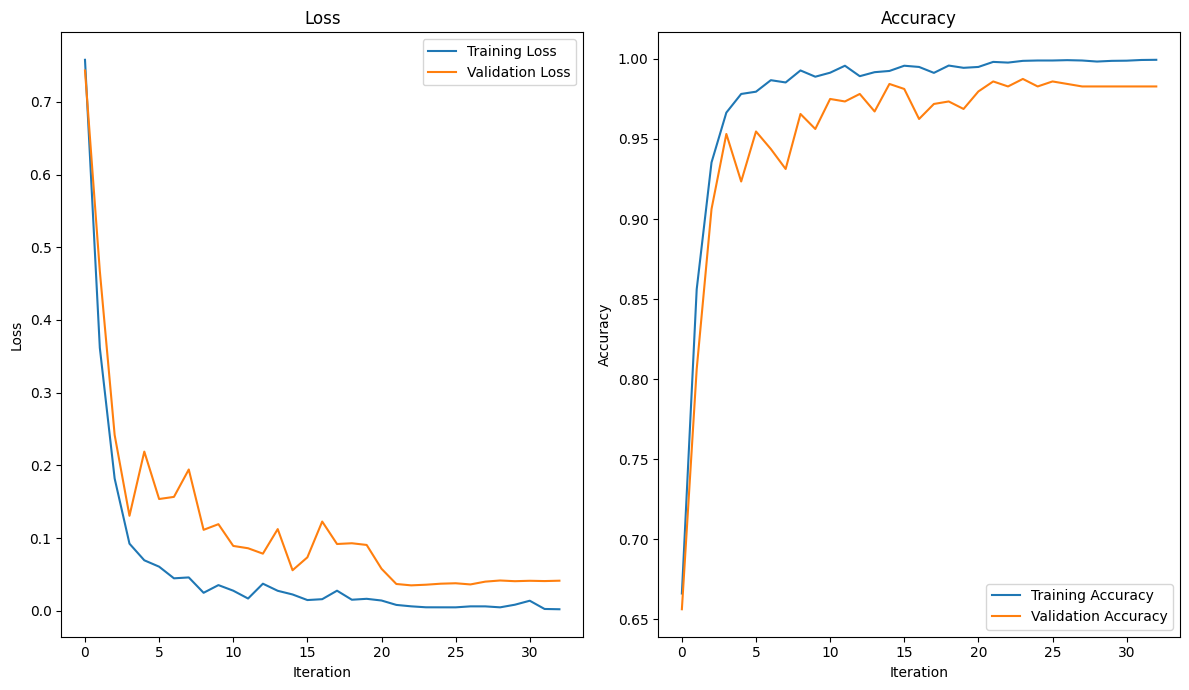

In [51]:
#Performance Curves

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [52]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [53]:
best_model = model
best_model.load_state_dict(torch.load('model_EfficientNet-B2.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.0922, Test Acc: 0.9789


In [54]:
#Classification Report

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.98      0.98      0.98       640
VeryMildDemented       0.96      0.98      0.97       448

        accuracy                           0.98      1280
       macro avg       0.99      0.98      0.98      1280
    weighted avg       0.98      0.98      0.98      1280



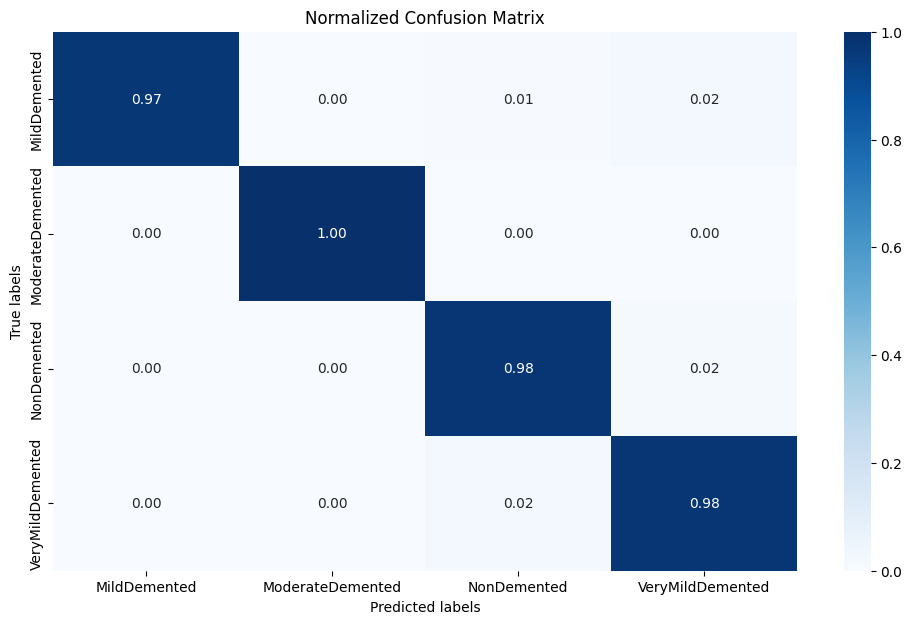

In [55]:
#Confusion Matrix

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


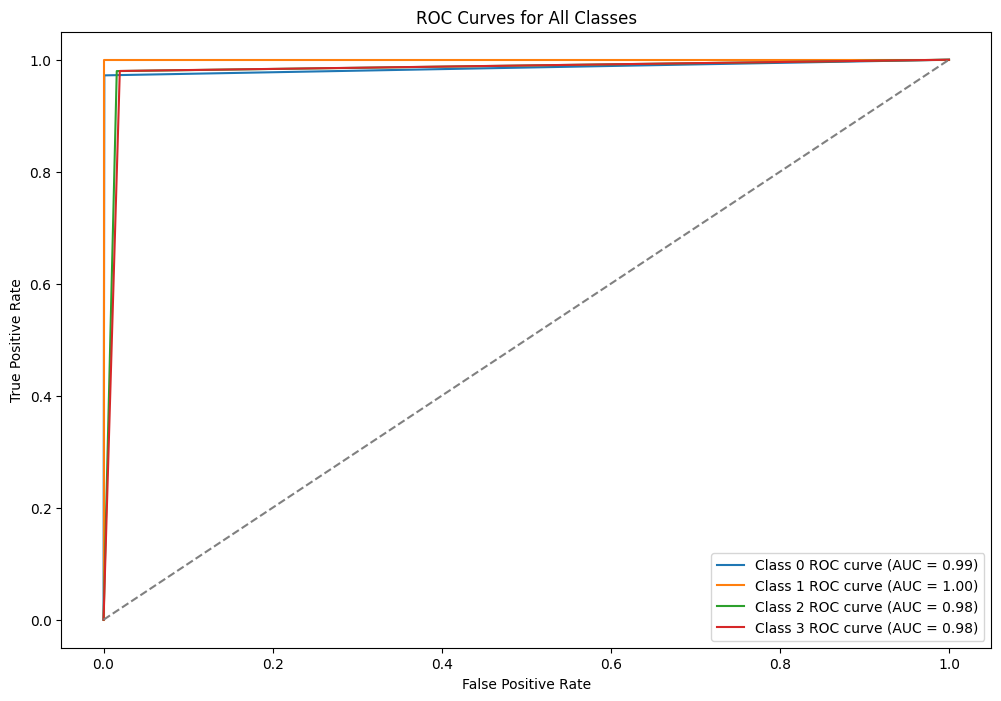

AUC for class 0: 0.99
AUC for class 1: 1.00
AUC for class 2: 0.98
AUC for class 3: 0.98


In [56]:
#ROC/AUC

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


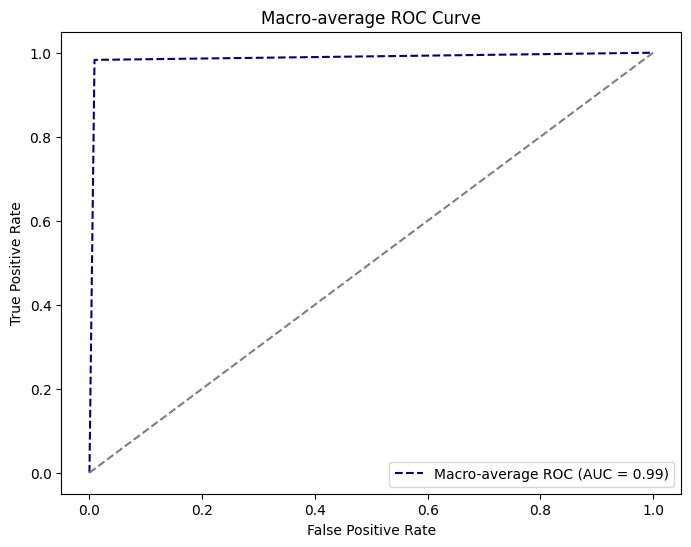

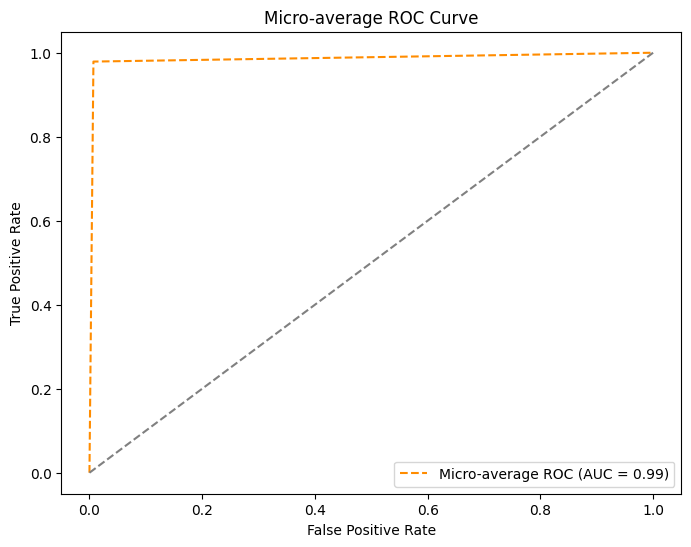

In [57]:
#ROC/AUC Combination

from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


**Model_xceptionNet**

In [13]:
#Train Function

# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    
    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()
              

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_xception.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [14]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [15]:
import timm

# Creating the model
def create_model(num_classes=4):
    # Load the pre-trained Xception model using timm
    model = timm.create_model('xception', pretrained=True)
    
    # Get the number of input features for the final classifier layer
    in_features = model.fc.in_features
    
    # Replace the final fully connected layer to match the number of classes
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:02<00:00,  9.21batch/s]


--> Epoch Number : 1 | Training Loss : 0.6076 | Validation Loss : 0.3657 | Train Accuracy : 73.03% | Validation Accuracy : 85.62%
Validation loss decreased (inf --> 0.365665).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:02<00:00,  9.04batch/s]


--> Epoch Number : 2 | Training Loss : 0.1782 | Validation Loss : 0.1673 | Train Accuracy : 93.83% | Validation Accuracy : 93.91%
Validation loss decreased (0.365665 --> 0.167345).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s]


--> Epoch Number : 3 | Training Loss : 0.0656 | Validation Loss : 0.2101 | Train Accuracy : 98.01% | Validation Accuracy : 92.19%
No reduction in validation loss | Patience count: 1


Epoch 4/50: 100%|██████████| 20/20 [00:02<00:00,  8.94batch/s]


--> Epoch Number : 4 | Training Loss : 0.035 | Validation Loss : 0.3554 | Train Accuracy : 98.97% | Validation Accuracy : 85.94%
No reduction in validation loss | Patience count: 2


Epoch 5/50: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s]


--> Epoch Number : 5 | Training Loss : 0.0278 | Validation Loss : 0.186 | Train Accuracy : 99.14% | Validation Accuracy : 92.34%
No reduction in validation loss | Patience count: 3


Epoch 6/50: 100%|██████████| 20/20 [00:02<00:00,  9.29batch/s]


--> Epoch Number : 6 | Training Loss : 0.0329 | Validation Loss : 0.2436 | Train Accuracy : 98.94% | Validation Accuracy : 91.56%
No reduction in validation loss | Patience count: 4


Epoch 7/50: 100%|██████████| 20/20 [00:02<00:00,  9.35batch/s]


--> Epoch Number : 7 | Training Loss : 0.0301 | Validation Loss : 0.1135 | Train Accuracy : 99.07% | Validation Accuracy : 96.56%
Validation loss decreased (0.167345 --> 0.113544).  Saving model ...


Epoch 8/50: 100%|██████████| 20/20 [00:02<00:00,  9.28batch/s]


--> Epoch Number : 8 | Training Loss : 0.0352 | Validation Loss : 0.1903 | Train Accuracy : 98.88% | Validation Accuracy : 93.91%
No reduction in validation loss | Patience count: 1


Epoch 9/50: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s]


--> Epoch Number : 9 | Training Loss : 0.0205 | Validation Loss : 0.1679 | Train Accuracy : 99.36% | Validation Accuracy : 95.0%
No reduction in validation loss | Patience count: 2


Epoch 10/50: 100%|██████████| 20/20 [00:02<00:00,  9.14batch/s]


--> Epoch Number : 10 | Training Loss : 0.0188 | Validation Loss : 0.1159 | Train Accuracy : 99.49% | Validation Accuracy : 95.94%
No reduction in validation loss | Patience count: 3


Epoch 11/50: 100%|██████████| 20/20 [00:02<00:00,  9.26batch/s]


--> Epoch Number : 11 | Training Loss : 0.037 | Validation Loss : 0.1057 | Train Accuracy : 98.91% | Validation Accuracy : 97.03%
Validation loss decreased (0.113544 --> 0.105653).  Saving model ...


Epoch 12/50: 100%|██████████| 20/20 [00:02<00:00,  9.13batch/s]


--> Epoch Number : 12 | Training Loss : 0.0207 | Validation Loss : 0.0503 | Train Accuracy : 99.4% | Validation Accuracy : 98.12%
Validation loss decreased (0.105653 --> 0.050306).  Saving model ...


Epoch 13/50: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s]


--> Epoch Number : 13 | Training Loss : 0.0074 | Validation Loss : 0.0908 | Train Accuracy : 99.8% | Validation Accuracy : 97.34%
No reduction in validation loss | Patience count: 1


Epoch 14/50: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s]


--> Epoch Number : 14 | Training Loss : 0.007 | Validation Loss : 0.0664 | Train Accuracy : 99.68% | Validation Accuracy : 97.66%
No reduction in validation loss | Patience count: 2


Epoch 15/50: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s]


--> Epoch Number : 15 | Training Loss : 0.009 | Validation Loss : 0.1006 | Train Accuracy : 99.68% | Validation Accuracy : 96.25%
No reduction in validation loss | Patience count: 3


Epoch 16/50: 100%|██████████| 20/20 [00:02<00:00,  9.21batch/s]


--> Epoch Number : 16 | Training Loss : 0.0187 | Validation Loss : 0.1226 | Train Accuracy : 99.42% | Validation Accuracy : 96.41%
No reduction in validation loss | Patience count: 4


Epoch 17/50: 100%|██████████| 20/20 [00:02<00:00,  9.23batch/s]


--> Epoch Number : 17 | Training Loss : 0.012 | Validation Loss : 0.1379 | Train Accuracy : 99.63% | Validation Accuracy : 95.78%
No reduction in validation loss | Patience count: 5


Epoch 18/50: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s]


--> Epoch Number : 18 | Training Loss : 0.0189 | Validation Loss : 0.1545 | Train Accuracy : 99.65% | Validation Accuracy : 94.84%
No reduction in validation loss | Patience count: 6


Epoch 19/50: 100%|██████████| 20/20 [00:02<00:00,  9.35batch/s]


--> Epoch Number : 19 | Training Loss : 0.01 | Validation Loss : 0.0872 | Train Accuracy : 99.85% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 7


Epoch 20/50: 100%|██████████| 20/20 [00:02<00:00,  9.19batch/s]


--> Epoch Number : 20 | Training Loss : 0.0028 | Validation Loss : 0.0814 | Train Accuracy : 99.99% | Validation Accuracy : 97.81%
No reduction in validation loss | Patience count: 8


Epoch 21/50: 100%|██████████| 20/20 [00:02<00:00,  9.04batch/s]


--> Epoch Number : 21 | Training Loss : 0.002 | Validation Loss : 0.0833 | Train Accuracy : 100.0% | Validation Accuracy : 97.66%
No reduction in validation loss | Patience count: 9


Epoch 22/50: 100%|██████████| 20/20 [00:02<00:00,  9.28batch/s]

--> Epoch Number : 22 | Training Loss : 0.0029 | Validation Loss : 0.0741 | Train Accuracy : 99.98% | Validation Accuracy : 97.81%
No reduction in validation loss | Patience count: 10
Early stopping triggered.


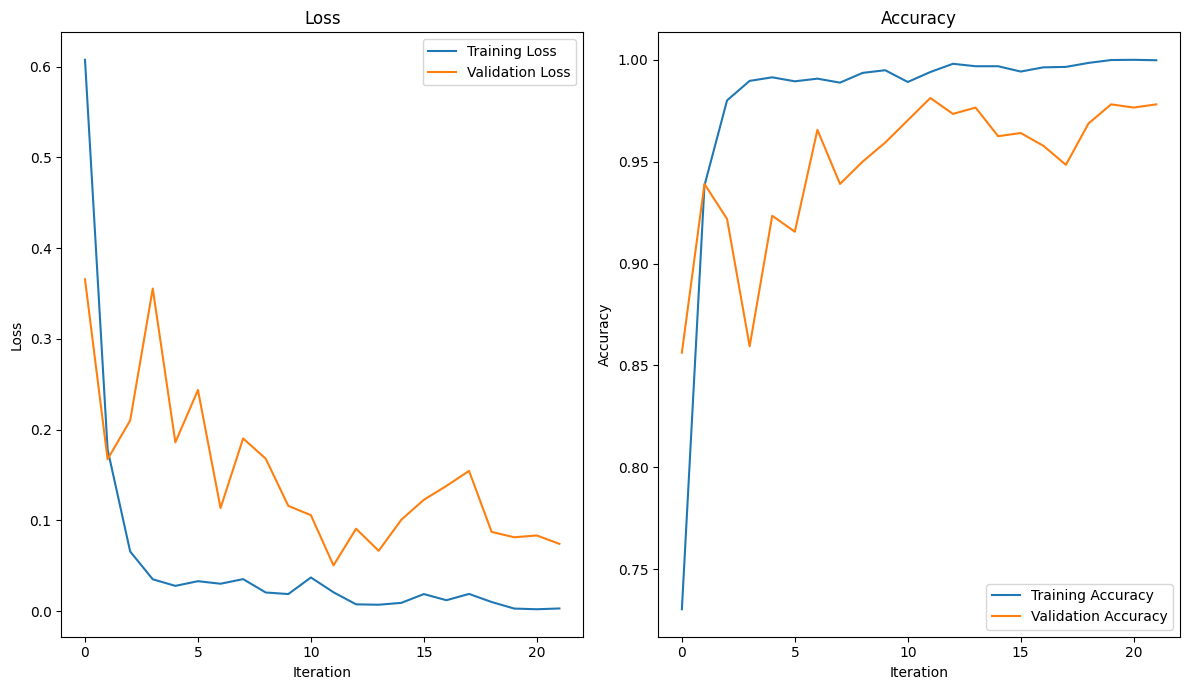

In [18]:
#Performance Curves

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [20]:
best_model = model
best_model.load_state_dict(torch.load('model_xception.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.0118, Test Acc: 0.9719


In [21]:
#Classification Report

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.94      1.00      0.97       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.97      0.97      0.97       640
VeryMildDemented       0.98      0.96      0.97       448

        accuracy                           0.97      1280
       macro avg       0.97      0.98      0.98      1280
    weighted avg       0.97      0.97      0.97      1280



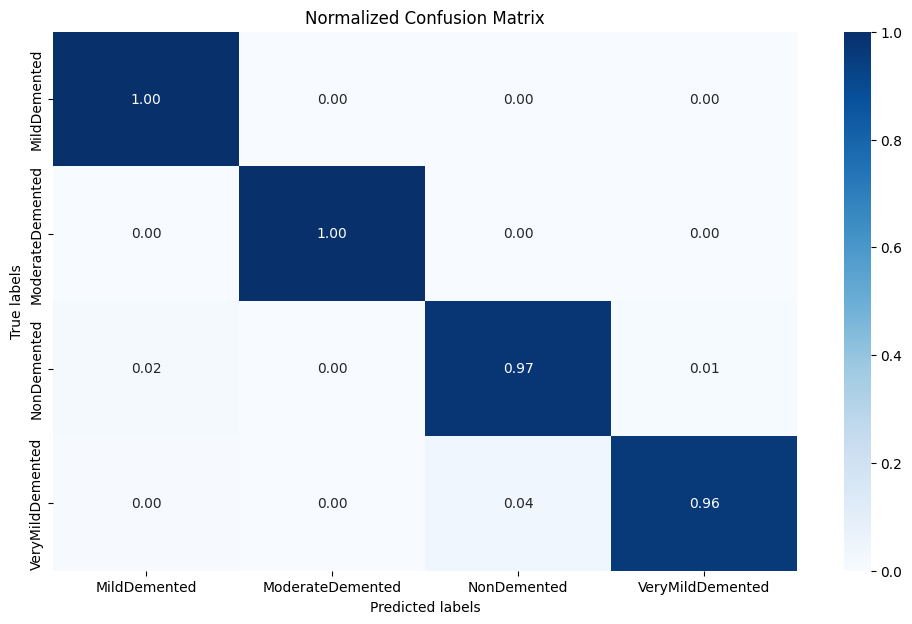

In [22]:
#Confusion Matrix

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


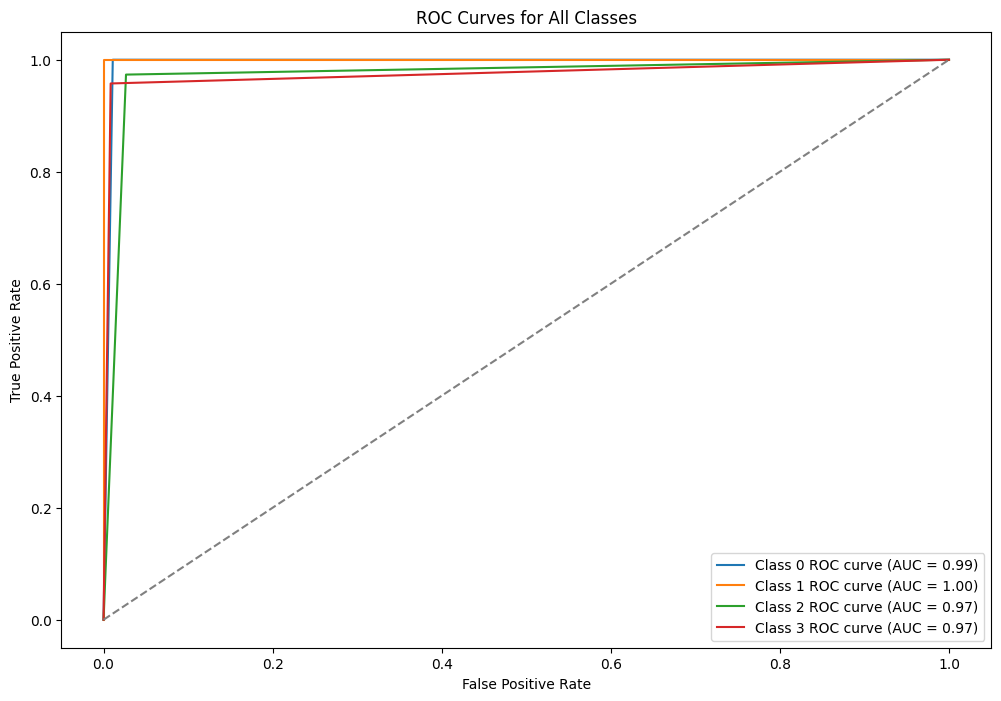

AUC for class 0: 0.99
AUC for class 1: 1.00
AUC for class 2: 0.97
AUC for class 3: 0.97


In [23]:
#ROC/AUC

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


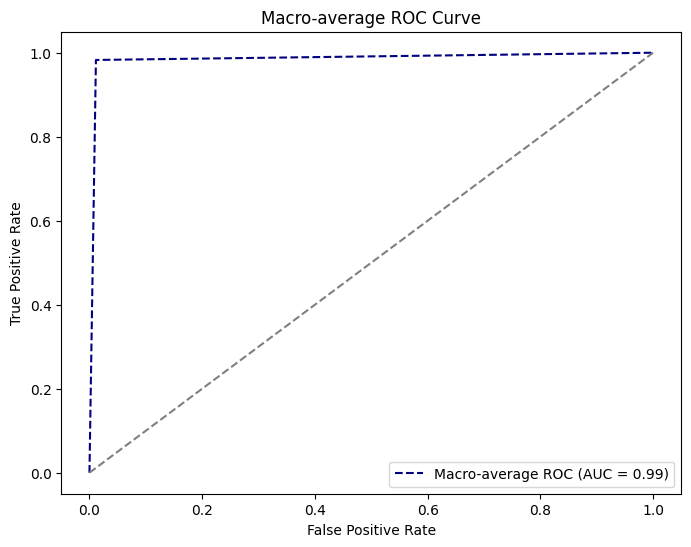

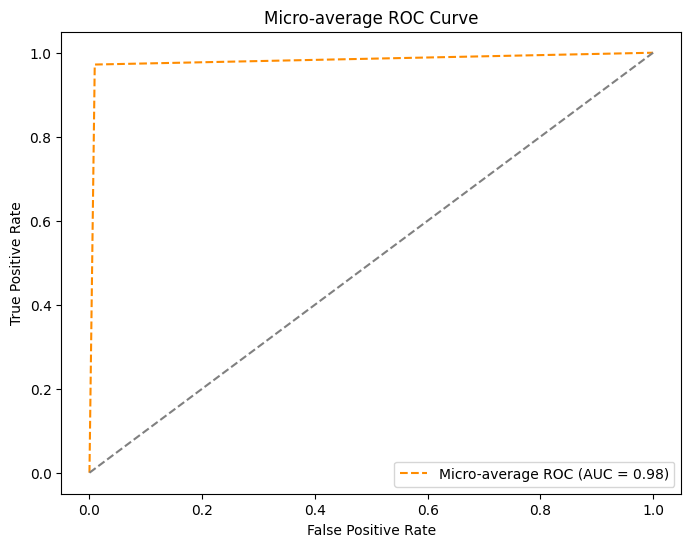

In [24]:
#ROC/AUC Combination

from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()



**CNN-Model**

In [37]:
# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    
    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()
              

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_cnn.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [39]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()

        # First Conv Block: Conv2D -> Relu -> MaxPooling2D -> BatchNorm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)

        # Second Conv Block: Conv2D -> Relu -> MaxPooling2D -> BatchNorm
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(64)

        # Third Conv Block: Conv2D -> Relu -> MaxPooling2D -> BatchNorm
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(128)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully Connected Block: Dense -> Relu -> Dropout -> Dense -> Dropout -> Output
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Adjust based on input image size
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass through the first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)

        # Pass through the second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)

        # Pass through the third convolutional block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.batchnorm3(x)

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Example usage
model = CNNModel(num_classes=4)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:00<00:00, 21.76batch/s]


--> Epoch Number : 1 | Training Loss : 1.2033 | Validation Loss : 1.1687 | Train Accuracy : 53.67% | Validation Accuracy : 60.94%
Validation loss decreased (inf --> 1.168677).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:00<00:00, 22.06batch/s]


--> Epoch Number : 2 | Training Loss : 1.0619 | Validation Loss : 1.1042 | Train Accuracy : 69.63% | Validation Accuracy : 63.28%
Validation loss decreased (1.168677 --> 1.104230).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:00<00:00, 22.58batch/s]


--> Epoch Number : 3 | Training Loss : 0.9938 | Validation Loss : 1.0537 | Train Accuracy : 76.48% | Validation Accuracy : 70.16%
Validation loss decreased (1.104230 --> 1.053714).  Saving model ...


Epoch 4/50: 100%|██████████| 20/20 [00:00<00:00, 21.76batch/s]


--> Epoch Number : 4 | Training Loss : 0.9294 | Validation Loss : 0.993 | Train Accuracy : 83.69% | Validation Accuracy : 77.5%
Validation loss decreased (1.053714 --> 0.992981).  Saving model ...


Epoch 5/50: 100%|██████████| 20/20 [00:00<00:00, 22.20batch/s]


--> Epoch Number : 5 | Training Loss : 0.8775 | Validation Loss : 0.9526 | Train Accuracy : 88.69% | Validation Accuracy : 81.25%
Validation loss decreased (0.992981 --> 0.952566).  Saving model ...


Epoch 6/50: 100%|██████████| 20/20 [00:00<00:00, 21.70batch/s]


--> Epoch Number : 6 | Training Loss : 0.834 | Validation Loss : 0.9286 | Train Accuracy : 92.97% | Validation Accuracy : 82.5%
Validation loss decreased (0.952566 --> 0.928622).  Saving model ...


Epoch 7/50: 100%|██████████| 20/20 [00:00<00:00, 20.93batch/s]


--> Epoch Number : 7 | Training Loss : 0.8036 | Validation Loss : 0.881 | Train Accuracy : 95.72% | Validation Accuracy : 88.44%
Validation loss decreased (0.928622 --> 0.880954).  Saving model ...


Epoch 8/50: 100%|██████████| 20/20 [00:00<00:00, 21.24batch/s]


--> Epoch Number : 8 | Training Loss : 0.7832 | Validation Loss : 0.866 | Train Accuracy : 97.46% | Validation Accuracy : 88.75%
Validation loss decreased (0.880954 --> 0.865967).  Saving model ...


Epoch 9/50: 100%|██████████| 20/20 [00:00<00:00, 21.15batch/s]


--> Epoch Number : 9 | Training Loss : 0.7701 | Validation Loss : 0.8301 | Train Accuracy : 98.22% | Validation Accuracy : 93.28%
Validation loss decreased (0.865967 --> 0.830133).  Saving model ...


Epoch 10/50: 100%|██████████| 20/20 [00:00<00:00, 21.71batch/s]


--> Epoch Number : 10 | Training Loss : 0.7627 | Validation Loss : 0.828 | Train Accuracy : 98.93% | Validation Accuracy : 92.97%
Validation loss decreased (0.830133 --> 0.828028).  Saving model ...


Epoch 11/50: 100%|██████████| 20/20 [00:00<00:00, 21.40batch/s]


--> Epoch Number : 11 | Training Loss : 0.7592 | Validation Loss : 0.8172 | Train Accuracy : 99.07% | Validation Accuracy : 93.44%
Validation loss decreased (0.828028 --> 0.817154).  Saving model ...


Epoch 12/50: 100%|██████████| 20/20 [00:00<00:00, 21.90batch/s]


--> Epoch Number : 12 | Training Loss : 0.7539 | Validation Loss : 0.8126 | Train Accuracy : 99.5% | Validation Accuracy : 93.91%
Validation loss decreased (0.817154 --> 0.812582).  Saving model ...


Epoch 13/50: 100%|██████████| 20/20 [00:00<00:00, 22.11batch/s]


--> Epoch Number : 13 | Training Loss : 0.7524 | Validation Loss : 0.8087 | Train Accuracy : 99.51% | Validation Accuracy : 94.06%
Validation loss decreased (0.812582 --> 0.808692).  Saving model ...


Epoch 14/50: 100%|██████████| 20/20 [00:00<00:00, 20.37batch/s]


--> Epoch Number : 14 | Training Loss : 0.7513 | Validation Loss : 0.8095 | Train Accuracy : 99.59% | Validation Accuracy : 94.22%
No reduction in validation loss | Patience count: 1


Epoch 15/50: 100%|██████████| 20/20 [00:00<00:00, 21.60batch/s]


--> Epoch Number : 15 | Training Loss : 0.7521 | Validation Loss : 0.813 | Train Accuracy : 99.43% | Validation Accuracy : 94.22%
No reduction in validation loss | Patience count: 2


Epoch 16/50: 100%|██████████| 20/20 [00:00<00:00, 21.49batch/s]


--> Epoch Number : 16 | Training Loss : 0.7509 | Validation Loss : 0.8056 | Train Accuracy : 99.54% | Validation Accuracy : 94.38%
Validation loss decreased (0.808692 --> 0.805560).  Saving model ...


Epoch 17/50: 100%|██████████| 20/20 [00:01<00:00, 17.02batch/s]


--> Epoch Number : 17 | Training Loss : 0.7491 | Validation Loss : 0.7902 | Train Accuracy : 99.66% | Validation Accuracy : 95.78%
Validation loss decreased (0.805560 --> 0.790225).  Saving model ...


Epoch 18/50: 100%|██████████| 20/20 [00:00<00:00, 21.71batch/s]


--> Epoch Number : 18 | Training Loss : 0.7478 | Validation Loss : 0.7872 | Train Accuracy : 99.71% | Validation Accuracy : 96.09%
Validation loss decreased (0.790225 --> 0.787234).  Saving model ...


Epoch 19/50: 100%|██████████| 20/20 [00:00<00:00, 21.77batch/s]


--> Epoch Number : 19 | Training Loss : 0.7495 | Validation Loss : 0.8003 | Train Accuracy : 99.6% | Validation Accuracy : 95.16%
No reduction in validation loss | Patience count: 1


Epoch 20/50: 100%|██████████| 20/20 [00:00<00:00, 21.14batch/s]


--> Epoch Number : 20 | Training Loss : 0.7513 | Validation Loss : 0.8192 | Train Accuracy : 99.51% | Validation Accuracy : 92.34%
No reduction in validation loss | Patience count: 2


Epoch 21/50: 100%|██████████| 20/20 [00:00<00:00, 22.08batch/s]


--> Epoch Number : 21 | Training Loss : 0.7516 | Validation Loss : 0.8006 | Train Accuracy : 99.43% | Validation Accuracy : 95.31%
No reduction in validation loss | Patience count: 3


Epoch 22/50: 100%|██████████| 20/20 [00:00<00:00, 22.06batch/s]


--> Epoch Number : 22 | Training Loss : 0.7494 | Validation Loss : 0.8574 | Train Accuracy : 99.64% | Validation Accuracy : 89.53%
No reduction in validation loss | Patience count: 4


Epoch 23/50: 100%|██████████| 20/20 [00:00<00:00, 20.49batch/s]


--> Epoch Number : 23 | Training Loss : 0.7489 | Validation Loss : 0.7821 | Train Accuracy : 99.62% | Validation Accuracy : 96.56%
Validation loss decreased (0.787234 --> 0.782078).  Saving model ...


Epoch 24/50: 100%|██████████| 20/20 [00:00<00:00, 22.19batch/s]


--> Epoch Number : 24 | Training Loss : 0.7466 | Validation Loss : 0.7818 | Train Accuracy : 99.76% | Validation Accuracy : 96.72%
Validation loss decreased (0.782078 --> 0.781776).  Saving model ...


Epoch 25/50: 100%|██████████| 20/20 [00:00<00:00, 21.73batch/s]


--> Epoch Number : 25 | Training Loss : 0.7467 | Validation Loss : 0.7823 | Train Accuracy : 99.77% | Validation Accuracy : 96.25%
No reduction in validation loss | Patience count: 1


Epoch 26/50: 100%|██████████| 20/20 [00:00<00:00, 22.23batch/s]


--> Epoch Number : 26 | Training Loss : 0.7466 | Validation Loss : 0.7784 | Train Accuracy : 99.76% | Validation Accuracy : 96.72%
Validation loss decreased (0.781776 --> 0.778375).  Saving model ...


Epoch 27/50: 100%|██████████| 20/20 [00:00<00:00, 21.94batch/s]


--> Epoch Number : 27 | Training Loss : 0.7494 | Validation Loss : 0.8152 | Train Accuracy : 99.58% | Validation Accuracy : 92.81%
No reduction in validation loss | Patience count: 1


Epoch 28/50: 100%|██████████| 20/20 [00:00<00:00, 22.41batch/s]


--> Epoch Number : 28 | Training Loss : 0.7498 | Validation Loss : 0.8147 | Train Accuracy : 99.54% | Validation Accuracy : 92.5%
No reduction in validation loss | Patience count: 2


Epoch 29/50: 100%|██████████| 20/20 [00:00<00:00, 22.19batch/s]


--> Epoch Number : 29 | Training Loss : 0.7483 | Validation Loss : 0.7924 | Train Accuracy : 99.65% | Validation Accuracy : 94.69%
No reduction in validation loss | Patience count: 3


Epoch 30/50: 100%|██████████| 20/20 [00:00<00:00, 22.11batch/s]


--> Epoch Number : 30 | Training Loss : 0.7489 | Validation Loss : 0.806 | Train Accuracy : 99.6% | Validation Accuracy : 93.59%
No reduction in validation loss | Patience count: 4


Epoch 31/50: 100%|██████████| 20/20 [00:00<00:00, 22.58batch/s]


--> Epoch Number : 31 | Training Loss : 0.7485 | Validation Loss : 0.7964 | Train Accuracy : 99.64% | Validation Accuracy : 94.69%
No reduction in validation loss | Patience count: 5


Epoch 32/50: 100%|██████████| 20/20 [00:00<00:00, 21.46batch/s]


--> Epoch Number : 32 | Training Loss : 0.7473 | Validation Loss : 0.7971 | Train Accuracy : 99.7% | Validation Accuracy : 95.0%
No reduction in validation loss | Patience count: 6


Epoch 33/50: 100%|██████████| 20/20 [00:00<00:00, 21.64batch/s]


--> Epoch Number : 33 | Training Loss : 0.7463 | Validation Loss : 0.7781 | Train Accuracy : 99.79% | Validation Accuracy : 96.88%
Validation loss decreased (0.778375 --> 0.778105).  Saving model ...


Epoch 34/50: 100%|██████████| 20/20 [00:00<00:00, 21.55batch/s]


--> Epoch Number : 34 | Training Loss : 0.746 | Validation Loss : 0.7791 | Train Accuracy : 99.8% | Validation Accuracy : 96.72%
No reduction in validation loss | Patience count: 1


Epoch 35/50: 100%|██████████| 20/20 [00:00<00:00, 21.68batch/s]


--> Epoch Number : 35 | Training Loss : 0.7459 | Validation Loss : 0.7781 | Train Accuracy : 99.8% | Validation Accuracy : 96.88%
Validation loss decreased (0.778105 --> 0.778059).  Saving model ...


Epoch 36/50: 100%|██████████| 20/20 [00:00<00:00, 20.65batch/s]


--> Epoch Number : 36 | Training Loss : 0.7458 | Validation Loss : 0.7776 | Train Accuracy : 99.8% | Validation Accuracy : 96.88%
Validation loss decreased (0.778059 --> 0.777610).  Saving model ...


Epoch 37/50: 100%|██████████| 20/20 [00:00<00:00, 22.18batch/s]


--> Epoch Number : 37 | Training Loss : 0.7458 | Validation Loss : 0.7775 | Train Accuracy : 99.79% | Validation Accuracy : 96.88%
Validation loss decreased (0.777610 --> 0.777549).  Saving model ...


Epoch 38/50: 100%|██████████| 20/20 [00:00<00:00, 22.09batch/s]


--> Epoch Number : 38 | Training Loss : 0.7457 | Validation Loss : 0.7771 | Train Accuracy : 99.81% | Validation Accuracy : 96.88%
Validation loss decreased (0.777549 --> 0.777093).  Saving model ...


Epoch 39/50: 100%|██████████| 20/20 [00:01<00:00, 17.76batch/s]


--> Epoch Number : 39 | Training Loss : 0.7456 | Validation Loss : 0.7778 | Train Accuracy : 99.81% | Validation Accuracy : 96.72%
No reduction in validation loss | Patience count: 1


Epoch 40/50: 100%|██████████| 20/20 [00:00<00:00, 21.22batch/s]


--> Epoch Number : 40 | Training Loss : 0.7456 | Validation Loss : 0.7768 | Train Accuracy : 99.81% | Validation Accuracy : 96.72%
Validation loss decreased (0.777093 --> 0.776838).  Saving model ...


Epoch 41/50: 100%|██████████| 20/20 [00:00<00:00, 21.82batch/s]


--> Epoch Number : 41 | Training Loss : 0.7455 | Validation Loss : 0.7769 | Train Accuracy : 99.83% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 1


Epoch 42/50: 100%|██████████| 20/20 [00:00<00:00, 22.17batch/s]


--> Epoch Number : 42 | Training Loss : 0.7455 | Validation Loss : 0.7772 | Train Accuracy : 99.83% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 2


Epoch 43/50: 100%|██████████| 20/20 [00:00<00:00, 21.80batch/s]


--> Epoch Number : 43 | Training Loss : 0.7455 | Validation Loss : 0.7774 | Train Accuracy : 99.83% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 3


Epoch 44/50: 100%|██████████| 20/20 [00:00<00:00, 21.74batch/s]


--> Epoch Number : 44 | Training Loss : 0.7455 | Validation Loss : 0.7777 | Train Accuracy : 99.83% | Validation Accuracy : 96.88%
No reduction in validation loss | Patience count: 4


Epoch 45/50: 100%|██████████| 20/20 [00:00<00:00, 22.20batch/s]


--> Epoch Number : 45 | Training Loss : 0.7455 | Validation Loss : 0.778 | Train Accuracy : 99.83% | Validation Accuracy : 96.56%
No reduction in validation loss | Patience count: 5


Epoch 46/50: 100%|██████████| 20/20 [00:00<00:00, 22.27batch/s]


--> Epoch Number : 46 | Training Loss : 0.7455 | Validation Loss : 0.7769 | Train Accuracy : 99.83% | Validation Accuracy : 96.56%
No reduction in validation loss | Patience count: 6


Epoch 47/50: 100%|██████████| 20/20 [00:00<00:00, 22.20batch/s]


--> Epoch Number : 47 | Training Loss : 0.7455 | Validation Loss : 0.7769 | Train Accuracy : 99.83% | Validation Accuracy : 96.56%
No reduction in validation loss | Patience count: 7


Epoch 48/50: 100%|██████████| 20/20 [00:00<00:00, 21.97batch/s]


--> Epoch Number : 48 | Training Loss : 0.7455 | Validation Loss : 0.7775 | Train Accuracy : 99.83% | Validation Accuracy : 96.56%
No reduction in validation loss | Patience count: 8


Epoch 49/50: 100%|██████████| 20/20 [00:00<00:00, 21.78batch/s]


--> Epoch Number : 49 | Training Loss : 0.7455 | Validation Loss : 0.7767 | Train Accuracy : 99.83% | Validation Accuracy : 96.56%
Validation loss decreased (0.776838 --> 0.776707).  Saving model ...


Epoch 50/50: 100%|██████████| 20/20 [00:00<00:00, 21.87batch/s]

--> Epoch Number : 50 | Training Loss : 0.7455 | Validation Loss : 0.777 | Train Accuracy : 99.83% | Validation Accuracy : 96.72%
No reduction in validation loss | Patience count: 1


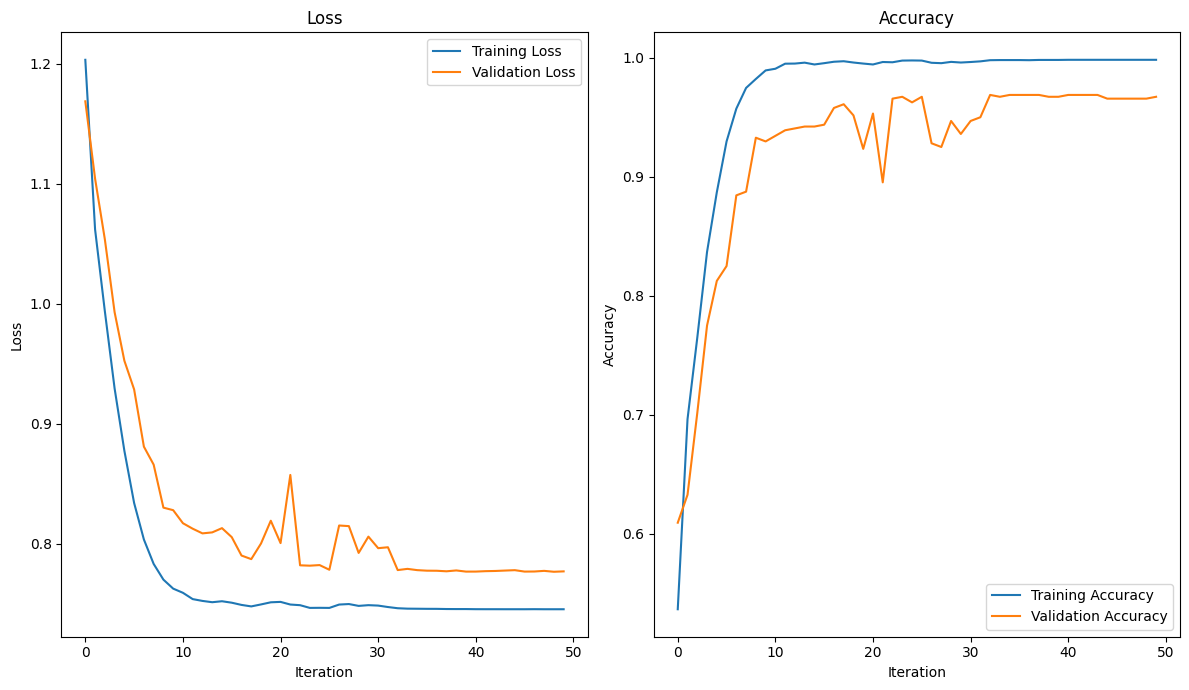

In [42]:
#Performance Curves

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [43]:
#Test Function

def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)

            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()

    test_cost /= len(test_loader)
    test_acc = test_correct / N_test

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [44]:
best_model = model
best_model.load_state_dict(torch.load('model_cnn.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.7851, Test Acc: 0.9773


In [45]:
#Classification Report

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)

    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction

        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.99      0.95      0.97       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.97      0.99      0.98       640
VeryMildDemented       0.98      0.97      0.97       448

        accuracy                           0.98      1280
       macro avg       0.99      0.98      0.98      1280
    weighted avg       0.98      0.98      0.98      1280



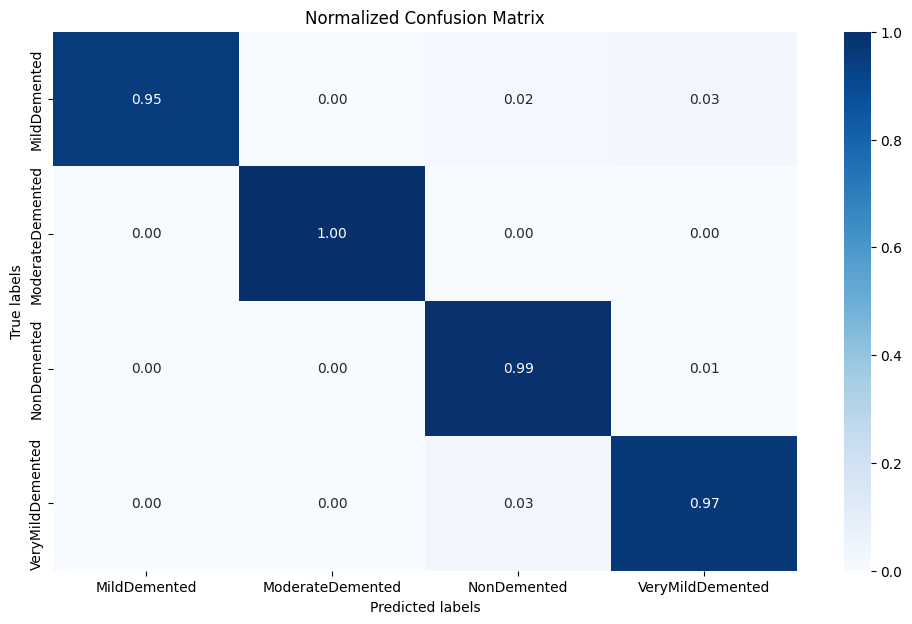

In [46]:
#Confusion Matrix

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


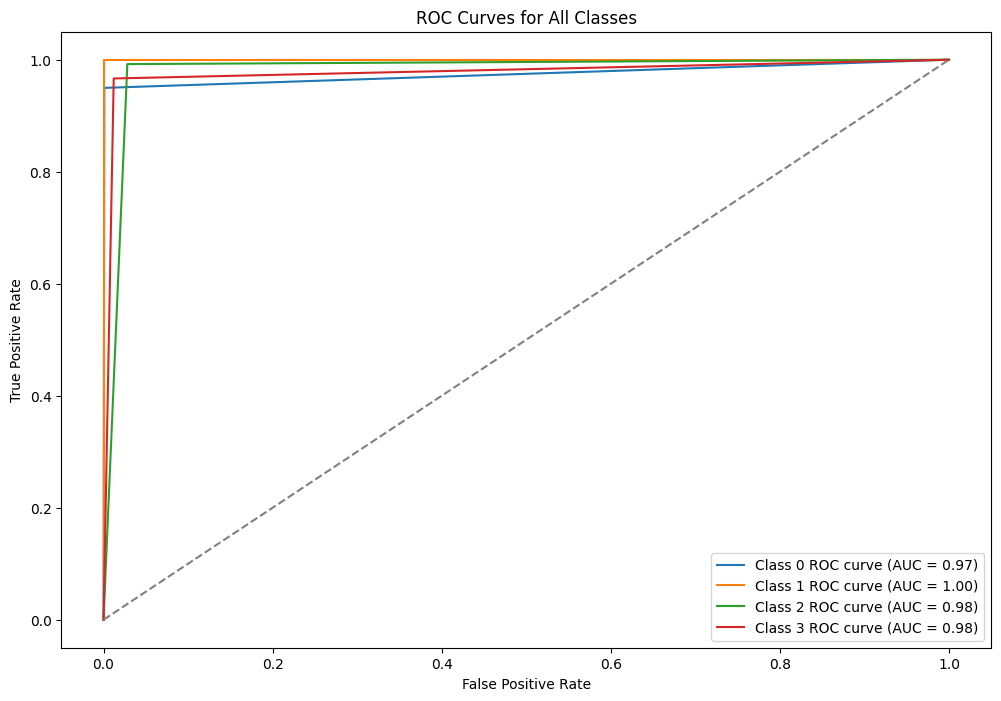

AUC for class 0: 0.97
AUC for class 1: 1.00
AUC for class 2: 0.98
AUC for class 3: 0.98


In [47]:
#ROC/AUC

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


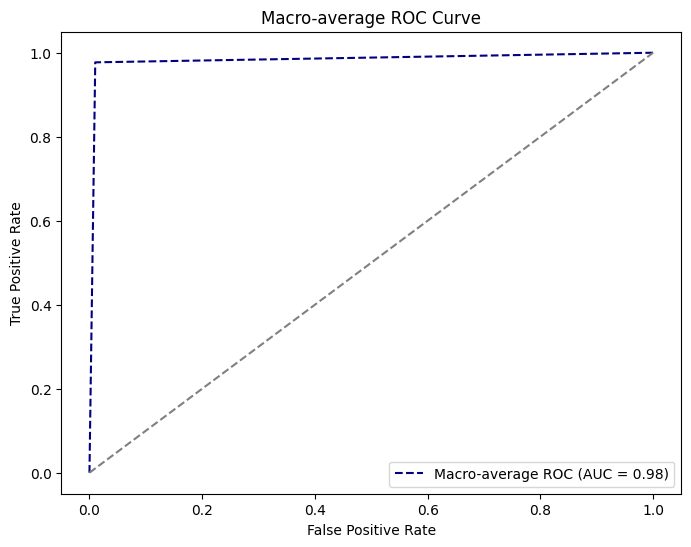

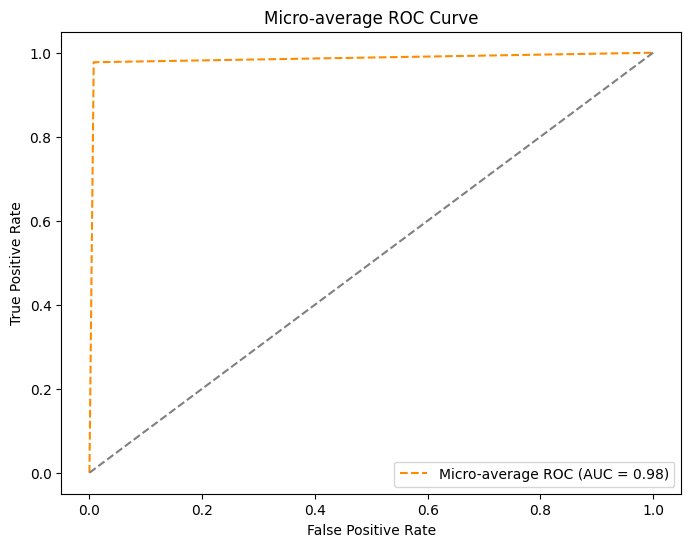

In [48]:
#ROC/AUC Combination

from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()
